<a href="https://colab.research.google.com/github/adityamishra5050/Sentiment-Analysis-of-Company-Reviews-/blob/main/DL_Project_Sentiment_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#library imports
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import spacy
#import jovian
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#loading the data
reviews = pd.read_csv("/content/drive/MyDrive/DLP/train.csv")
print(reviews.shape)
reviews.head()

(60000, 3)


,Id,Review,Rating
0,0,Very good value and a great tv very happy and ...,5
1,1,After 6 month still can't access my account,3
2,2,I couldn't make an official review on a produc...,1
3,3,"Fantastic! Extremely easy to use website, fant...",5
4,4,So far annoyed as hell with this bt monthly pa...,1


In [ ]:
#keeping only relevant columns and calculating sentence lengths
reviews = reviews[['Review', 'Rating']]
reviews.columns = ['Review', 'Rating']
reviews['review_length'] = reviews['Review'].apply(lambda x: len(x.split()))
reviews.head()

,Review,Rating,review_length
0,Very good value and a great tv very happy and ...,5,18
1,After 6 month still can't access my account,3,8
2,I couldn't make an official review on a produc...,1,92
3,"Fantastic! Extremely easy to use website, fant...",5,32
4,So far annoyed as hell with this bt monthly pa...,1,49


In [ ]:
#changing ratings to 0-numbering
zero_numbering = {1:0, 2:1, 3:2, 4:3, 5:4}
reviews['Rating'] = reviews['Rating'].apply(lambda x: zero_numbering[x])

In [ ]:
#mean sentence length
np.mean(reviews['review_length'])

56.56325

In [ ]:
#tokenization
tok = spacy.load('en_core_web_sm')
def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

In [ ]:
#count number of occurences of each word
counts = Counter()
for index, row in reviews.iterrows():
    counts.update(tokenize(row['Review']))

In [ ]:
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 29235
num_words after: 16303


In [ ]:
#creating vocabulary
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

Doing padding

In [ ]:
def encode_sentence(text, vocab2index, N=70):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [ ]:
reviews['encoded'] = reviews['Review'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
reviews.head()

<ipython-input-12-e8e4138cbc8c>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  reviews['encoded'] = reviews['Review'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))


,Review,Rating,review_length,encoded
0,Very good value and a great tv very happy and ...,4,18,"[[2, 3, 4, 5, 6, 7, 8, 2, 9, 5, 10, 11, 12, 5,..."
1,After 6 month still can't access my account,2,8,"[[17, 18, 19, 20, 21, 22, 23, 24, 25, 0, 0, 0,..."
2,I couldn't make an official review on a produc...,0,92,"[[26, 27, 22, 28, 29, 30, 31, 32, 6, 33, 32, 3..."
3,"Fantastic! Extremely easy to use website, fant...",4,32,"[[87, 39, 88, 89, 62, 90, 91, 39, 87, 92, 93, ..."
4,So far annoyed as hell with this bt monthly pa...,0,49,"[[36, 105, 106, 60, 107, 53, 57, 108, 109, 110..."


In [ ]:
#check how balanced the dataset is
Counter(reviews['Rating'])

Counter({4: 34679, 2: 1679, 0: 18663, 3: 3350, 1: 1629})

In [ ]:
X = list(reviews['encoded'])
y = list(reviews['Rating'])
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [ ]:
class ReviewsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [ ]:
train_ds = ReviewsDataset(X_train, y_train)
valid_ds = ReviewsDataset(X_valid, y_valid)

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix

In [ ]:
batch_size = 5000
vocab_size = len(words)
print(vocab_size)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

16305


In [ ]:
class RNN_fixed_len(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        rnn_out, ht = self.rnn(x)
        return self.linear(ht[-1])

In [ ]:
model1 =  RNN_fixed_len(vocab_size, 50, 50)

In [ ]:
def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

In [ ]:
class Multilayer_fixed_len(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        rnn_out, ht = self.rnn(x)
        return self.linear(ht[-1])

In [ ]:
model2 = Multilayer_fixed_len(vocab_size, 50, 50, 4)

In [ ]:
Train_Loss = []
Train_Acc = []
Val_Loss = []
Val_Acc = []


In [ ]:
parameters1 = filter(lambda p: p.requires_grad, model1.parameters())
optimizer1 = torch.optim.Adam(parameters1, lr=0.01)

epochs = 10



for i in range(epochs):
  model1.train()
  sum_loss1 = 0.0
  total1 = 0
  all_preds = []
  all_targets = []
  for x, y, l in train_dl:
    x = x.long()
    y = y.long()
    y_pred1 = model1(x, l)
    optimizer1.zero_grad()
    loss1 = F.cross_entropy(y_pred1, y)
    nn.BCEWithLogitsLoss()
    loss1.backward()
    optimizer1.step()
    sum_loss1 += loss1.item()*y.shape[0]
    total1 += y.shape[0]
    all_preds += y_pred1.tolist()
    all_targets += y.tolist()
  val_loss1, val_acc1, val_rmse1 = validation_metrics(model1, val_dl)
  _, train_acc1, _ = validation_metrics(model1, train_dl)
  Train_Acc.append(train_acc1)
  Train_Loss.append(sum_loss1/total1)
  Val_Loss.append(val_loss1)
  Val_Acc.append(val_acc1)
  print("train loss %.3f, train acc %.3f, trainval loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss1/total1, train_acc1, val_loss1, val_acc1, val_rmse1))



train loss 1.157, train acc 0.685, trainval loss 0.945, val accuracy 0.683, and val rmse 1.921
train loss 0.915, train acc 0.719, trainval loss 0.908, val accuracy 0.717, and val rmse 1.774
train loss 0.895, train acc 0.724, trainval loss 0.889, val accuracy 0.718, and val rmse 1.769
train loss 0.876, train acc 0.729, trainval loss 0.883, val accuracy 0.725, and val rmse 1.737
train loss 0.865, train acc 0.733, trainval loss 0.874, val accuracy 0.726, and val rmse 1.734
train loss 0.855, train acc 0.741, trainval loss 0.868, val accuracy 0.733, and val rmse 1.689
train loss 0.876, train acc 0.756, trainval loss 0.992, val accuracy 0.749, and val rmse 1.637
train loss 0.955, train acc 0.526, trainval loss 1.663, val accuracy 0.531, and val rmse 2.015
train loss 0.978, train acc 0.696, trainval loss 0.877, val accuracy 0.693, and val rmse 1.880
train loss 0.846, train acc 0.744, trainval loss 0.839, val accuracy 0.732, and val rmse 1.696


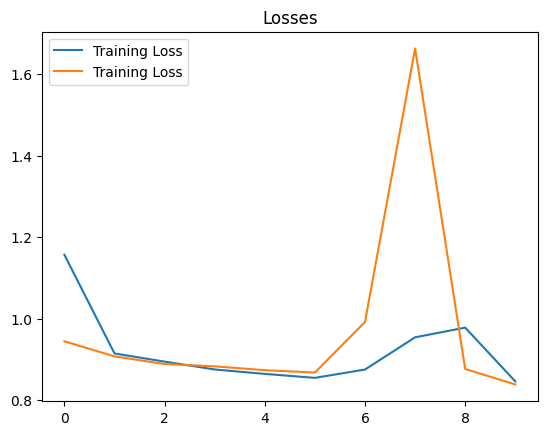

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Train_Loss, label='Training Loss')
plt.plot(Val_Loss, label='Training Loss')
plt.legend()
plt.title('Losses')
plt.show()

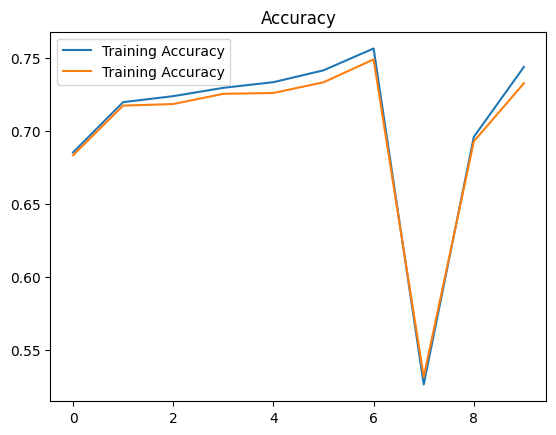

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Train_Acc, label='Training Accuracy')
plt.plot(Val_Acc, label='Training Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

In [ ]:
validation_metrics(model1,val_dl)

(0.8389011770486832, tensor(0.7324), 1.6955863002732225)

In [ ]:
true_labels = []
predicted_labels = []


In [ ]:
true_labels += y.tolist()
predicted_labels += torch.argmax(y_pred1, dim=1).tolist()

In [ ]:
'''
conf_mat = confusion_matrix(true_labels, predicted_labels)
print(conf_mat)
'''

ValueError: ignored

In [ ]:

'''
import seaborn as sns
plt.figure(figsize=(5, 5))
sns.heatmap(conf_mat, cmap='icefire', annot=True, linewidths=0.1,
           fmt = ',')
plt.title('Confusion Matrix: CNN', fontsize=12);
'''

In [ ]:
Train_Loss1 = []
Train_Acc1 = []
Val_Loss1 = []
Val_Acc1 = []


In [ ]:
parameters2 = filter(lambda p: p.requires_grad, model2.parameters())
optimizer2 = torch.optim.Adam(parameters2, lr=0.01)

epochs = 10



for i in range(epochs):
  model2.train()
  sum_loss2 = 0.0
  total2 = 0
  all_preds1 = []
  all_targets1 = []
  for x, y, l in train_dl:
    x = x.long()
    y = y.long()
    y_pred2 = model2(x, l)
    optimizer2.zero_grad()
    loss2 = F.cross_entropy(y_pred2, y)
    nn.BCEWithLogitsLoss()
    loss2.backward()
    optimizer2.step()
    sum_loss2 += loss2.item()*y.shape[0]
    total2 += y.shape[0]
    all_preds1 += y_pred2.tolist()
    all_targets1 += y.tolist()
  val_loss2, val_acc2, val_rmse2 = validation_metrics(model2, val_dl)
  _, train_acc2, _ = validation_metrics(model2, train_dl)
  Train_Acc1.append(train_acc2)
  Train_Loss1.append(sum_loss2/total2)
  Val_Loss1.append(val_loss2)
  Val_Acc1.append(val_acc2)
  print("train loss %.3f, train acc %.3f, trainval loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss2/total2, train_acc2, val_loss2, val_acc2, val_rmse2))



train loss 1.124, train acc 0.424, trainval loss 1.357, val accuracy 0.425, and val rmse 2.831
train loss 1.261, train acc 0.526, trainval loss 1.182, val accuracy 0.529, and val rmse 2.314
train loss 1.156, train acc 0.510, trainval loss 1.134, val accuracy 0.515, and val rmse 2.357
train loss 1.057, train acc 0.577, trainval loss 1.016, val accuracy 0.583, and val rmse 2.304
train loss 0.996, train acc 0.719, trainval loss 0.914, val accuracy 0.720, and val rmse 1.763
train loss 0.954, train acc 0.725, trainval loss 0.910, val accuracy 0.724, and val rmse 1.742
train loss 0.889, train acc 0.729, trainval loss 0.875, val accuracy 0.728, and val rmse 1.725
train loss 0.929, train acc 0.577, trainval loss 1.016, val accuracy 0.583, and val rmse 2.304
train loss 0.984, train acc 0.680, trainval loss 0.961, val accuracy 0.674, and val rmse 1.953
train loss 0.946, train acc 0.680, trainval loss 0.947, val accuracy 0.678, and val rmse 1.936


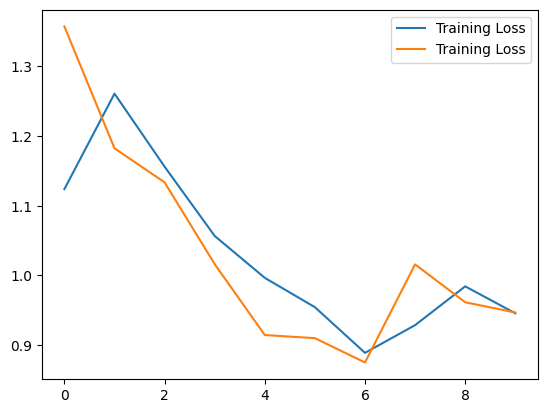

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Train_Loss1, label='Training Loss')
plt.plot(Val_Loss1, label='Validation Loss')
plt.legend()
#plt.title('Graph')
plt.show()

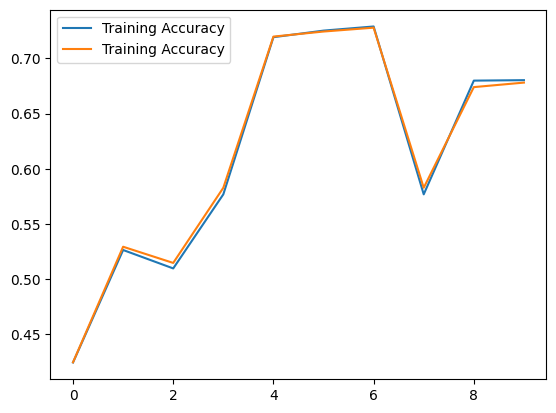

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Train_Acc1, label='Training Accuracy')
plt.plot(Val_Acc1, label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(all_labels,all_preds, average='weighted')
print(f"F1 score: {f1}")